# GloVe & CNN

GLOVE fonctionne de la même manière que Word2Vec. Alors que vous pouvez voir ci-dessus que Word2Vec est un modèle «prédictif» qui prédit un mot donné par le contexte, GLOVE apprend en construisant une matrice de cooccurrence (mots X contexte) qui compte essentiellement la fréquence d'apparition d'un mot dans un contexte. Comme il s'agira d'une matrice gigantesque, nous factorisons cette matrice pour obtenir une représentation de dimension inférieure. Il y a beaucoup de détails dans GLOVE mais c'est l'idée approximative.

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Activation, Dropout, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

2022-04-11 11:50:49.680829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-11 11:50:49.681241: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
pip install unidecode

Note: you may need to restart the kernel to use updated packages.


In [7]:
from NLP_Natural_Disasters.data import get_data, clean_data

In [8]:
train_df = get_data()
cleaned_df = clean_data(train_df)

Display full col. width 

In [9]:
pd.set_option('display.max_colwidth', None)

In [10]:
cleaned_df

,id,text,target
0,1,deed reason earthquake may allah forgive u,1
1,4,forest fire near la canada,1
2,5,resident asked shelter place officer evacuation shelter place order expected,1
3,6,people receive wildfire evacuation order california,1
4,7,got sent photo alaska smoke wildfire school,1
...,...,...,...
7608,10869,two giant crane holding bridge collapse nearby home,1
7609,10870,control wild fire california even northern part state troubling,1
7610,10871,utckm volcano hawaii,1
7611,10872,police investigating ebike collided car little portugal ebike rider suffered serious nonlife threatening injury,1


## Data Cleaning to add eventually 

Pour éviter les mots rares qui n'apparaissent qu'une fois type mot avec faute, contraction etc

In [8]:
#def transform_to_list_word(serie):
#    split_list=[]  
#    for sentence in serie.str.split():
#        for word in sentence:
#            split_list.append(word)
#    return split_list

In [9]:
#list_word = transform_to_list_word(cleaned_df['text'])
#len(list_word)

**POUR DATA CLEANING**

In [10]:
#twitts = ' '.join(cleaned_df['text'])
#twitts = twitts.split()
#freq_comm = pd.Series(twitts).value_counts()
#rare = freq_comm[freq_comm.values == 1]
#rare

In [11]:
#list_word_new = [word for word in list_word if word not in rare]
#len(list_word_new)

In [12]:
#cleaned_df

**POUR DATA CLEANING**

In [13]:
#%%time
#def get_clean_text(sentence):
#    if type(sentence) is str:
#        sentence = " " .join(word for word in sentence.split() if word not in rare)
#        return sentence

#cleaned_df['tweet'] = cleaned_df['text'].apply(lambda x: get_clean_text(x))

## Embedding

In [11]:
cleaned_df

,id,text,target
0,1,deed reason earthquake may allah forgive u,1
1,4,forest fire near la canada,1
2,5,resident asked shelter place officer evacuation shelter place order expected,1
3,6,people receive wildfire evacuation order california,1
4,7,got sent photo alaska smoke wildfire school,1
...,...,...,...
7608,10869,two giant crane holding bridge collapse nearby home,1
7609,10870,control wild fire california even northern part state troubling,1
7610,10871,utckm volcano hawaii,1
7611,10872,police investigating ebike collided car little portugal ebike rider suffered serious nonlife threatening injury,1


### Token

In [12]:
cleaned_df['target'].value_counts()

0    4335
1    3268
Name: target, dtype: int64

In [13]:
text = cleaned_df['text'].tolist()
text

['deed reason earthquake may allah forgive u',
 'forest fire near la canada',
 'resident asked shelter place officer evacuation shelter place order expected',
 'people receive wildfire evacuation order california',
 'got sent photo alaska smoke wildfire school',
 'rockyfire update california hwy closed due lake county fire cafire wildfire',
 'flood disaster heavy rain cause flash flooding street colorado spring area',
 'im top hill see fire wood',
 'there emergency evacuation happening building across street',
 'im afraid tornado coming area',
 'three people died heat wave far',
 'haha south tampa getting flooded hah wait second live south tampa gon na gon na flooding',
 'raining flooding florida tampa day ive lost count',
 'flood bago myanmar arrived bago',
 'damage school bus multi car crash breaking',
 'whats man',
 'love fruit',
 'summer lovely',
 'car fast',
 'ridiculous',
 'london cool',
 'love',
 'wonderful day',
 'cant eat shit',
 'nyc last week',
 'love girlfriend',
 'like pas

In [14]:
y = cleaned_df['target']

In [15]:
token = Tokenizer()
token.fit_on_texts(text)

In [16]:
vocab_size = len(token.word_index) + 1
vocab_size

5574

In [17]:
dict_token_tweet = token.index_word
dict_token_tweet

{1: 'fire',
 2: 'like',
 3: 'u',
 4: 'amp',
 5: 'im',
 6: 'get',
 7: 'new',
 8: 'via',
 9: 'one',
 10: 'people',
 11: 'news',
 12: 'dont',
 13: 'video',
 14: 'time',
 15: 'emergency',
 16: 'disaster',
 17: 'year',
 18: 'body',
 19: 'day',
 20: 'building',
 21: 'police',
 22: 'home',
 23: 'family',
 24: 'would',
 25: 'still',
 26: 'say',
 27: 'life',
 28: 'go',
 29: 'storm',
 30: 'got',
 31: 'crash',
 32: 'california',
 33: 'back',
 34: 'burning',
 35: 'look',
 36: 'know',
 37: 'bomb',
 38: 'world',
 39: 'suicide',
 40: 'train',
 41: 'flood',
 42: 'see',
 43: 'car',
 44: 'death',
 45: 'man',
 46: 'attack',
 47: 'rt',
 48: 'first',
 49: 'love',
 50: 'pm',
 51: 'going',
 52: 'cant',
 53: 'nuclear',
 54: 'make',
 55: 'two',
 56: 'today',
 57: 'war',
 58: 'dead',
 59: 'killed',
 60: 'accident',
 61: 'want',
 62: 'need',
 63: 'let',
 64: 'full',
 65: 'woman',
 66: 'hiroshima',
 67: 'good',
 68: 'think',
 69: 'may',
 70: 'take',
 71: 'weapon',
 72: 'way',
 73: 'watch',
 74: 'many',
 75: 'wild

In [18]:
encoded_text = token.texts_to_sequences(text)
encoded_text

[[3818, 448, 153, 69, 1382, 3819, 3],
 [110, 1, 148, 500, 1060],
 [1507, 1383, 1845, 449, 315, 160, 1845, 449, 357, 946],
 [10, 3820, 75, 160, 357, 32],
 [30, 1061, 111, 2107, 187, 75, 96],
 [2474, 188, 32, 1287, 723, 450, 886, 297, 1, 3821, 75],
 [41, 16, 724, 161, 122, 691, 177, 426, 887, 798, 189],
 [5, 140, 1136, 42, 1, 1846],
 [214, 15, 160, 1137, 20, 725, 426],
 [5, 2108, 298, 170, 189],
 [501, 10, 520, 215, 134, 521],
 [726,
  542,
  2475,
  143,
  2476,
  2993,
  522,
  358,
  126,
  542,
  2475,
  197,
  81,
  197,
  81,
  177],
 [2477, 177, 1847, 2475, 19, 231, 632, 3822],
 [41, 3823, 799, 1508, 3823],
 [135, 96, 190, 3824, 43, 31, 254],
 [502, 45],
 [49, 1509],
 [241, 1510],
 [43, 657],
 [2478],
 [888, 451],
 [49],
 [2109, 19],
 [52, 1665, 144],
 [1138, 76, 232],
 [49, 1848],
 [2, 3825],
 [191],
 [2479, 284, 543],
 [203, 658, 841, 724, 1062, 47],
 [254, 583, 162, 543, 1002],
 [800, 162, 543],
 [1511, 584, 35, 727, 76, 163, 543],
 [3826, 2110, 1849, 113, 2994, 285, 7, 3827, 2

In [19]:
size = []
for x in encoded_text:
    size.append(len(x))

max(size)

20

In [20]:
max_length = 25 #modifier par le nombre max de mots dans le dataset
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')
X

array([[3818,  448,  153, ...,    0,    0,    0],
       [ 110,    1,  148, ...,    0,    0,    0],
       [1507, 1383, 1845, ...,    0,    0,    0],
       ...,
       [3571,  441, 1371, ...,    0,    0,    0],
       [  21,  983, 2739, ...,    0,    0,    0],
       [ 130,   22,  447, ...,    0,    0,    0]], dtype=int32)

In [21]:
X.shape

(7603, 25)

### GloVe Vectors

In [8]:
glove_vectors = dict()

In [2]:
pwd

'/home/dianavo/code/AxelCatelan/NLP_Natural_Disasters/notebooks'

changer de directory

In [ ]:
# jupyter notebook --notebook-dir D:/home/dianavo/code/AxelCatelan/NLP_Natural_Disasters/

path du glove ... txt

In [4]:
#  \\wsl$\Ubuntu\home\dianavo\code\AxelCatelan\NLP_Natural_Disasters\glove

In [ ]:
%%time
file = open('../glove/glove.twitter.27B.200d.txt', encoding='utf-8')
# open('../glove/glove.twitter.27B.200d.txt', encoding='utf-8')

for line in file:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:])
    glove_vectors[word] = vectors
file.close()

In [ ]:
len(glove_vectors.keys())

In [ ]:
glove_vectors.get('random').shape

In [ ]:
word_vector_matrix = np.zeros((vocab_size,200))
to_delete = []

for word, index in token.word_index.items():
    vector = glove_vectors.get(word)
    if vector is not None:
        word_vector_matrix[index] = vector
    else :
        to_delete.append(word)

In [ ]:
to_delete

### TF2.0 and Keras Model Building

In [23]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size= 0.2, stratify = y)
vec_size = 200

In [47]:
model = Sequential()

es = EarlyStopping(patience=5)

model.add(Embedding(vocab_size, vec_size, input_length=max_length, weights = [word_vector_matrix], trainable = False))
model.add(Conv1D(64, 8, activation ='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy',f1_m,precision_m, recall_m])
history = model.fit(X_train, y_train, batch_size=16, epochs = 400, validation_data = (X_test, y_test), callbacks = [es])


Epoch 1/400
381/381 [==============================] - 2s 3ms/step - loss: 0.6801 - accuracy: 0.5936 - f1_m: 0.4319 - precision_m: 0.5250 - recall_m: 0.4060 - val_loss: 0.5941 - val_accuracy: 0.7653 - val_f1_m: 0.7119 - val_precision_m: 0.7266 - val_recall_m: 0.7308
Epoch 2/400
381/381 [==============================] - 1s 3ms/step - loss: 0.5923 - accuracy: 0.6934 - f1_m: 0.6032 - precision_m: 0.6499 - recall_m: 0.5931 - val_loss: 0.5282 - val_accuracy: 0.7876 - val_f1_m: 0.7336 - val_precision_m: 0.7608 - val_recall_m: 0.7361
Epoch 3/400
381/381 [==============================] - 1s 3ms/step - loss: 0.5528 - accuracy: 0.7335 - f1_m: 0.6519 - precision_m: 0.7069 - recall_m: 0.6405 - val_loss: 0.4960 - val_accuracy: 0.7890 - val_f1_m: 0.7333 - val_precision_m: 0.7636 - val_recall_m: 0.7315
Epoch 4/400
381/381 [==============================] - 1s 3ms/step - loss: 0.5168 - accuracy: 0.7647 - f1_m: 0.6902 - precision_m: 0.7544 - recall_m: 0.6680 - val_loss: 0.4770 - val_accuracy: 0.7936 

### Prédiction

In [28]:
def get_encode(phrase):
    phrase = token.texts_to_sequences([phrase])
    phrase = pad_sequences(phrase, maxlen=max_length, padding='post')
    return phrase

In [29]:
get_encode("hi how are you")

array([[1331,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]], dtype=int32)

In [30]:
model.predict_classes(get_encode("forest fire near la ronge sask canada"))

/Users/camillechatel/.pyenv/versions/3.8.12/envs/nlp_project/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1]], dtype=int32)

In [36]:
model.predict(get_encode("forest fire near la canada"))
#model.predict_classes

array([[0.96023333]], dtype=float32)

In [34]:
cleaned_df

,id,text,target
0,1,deed reason earthquake may allah forgive u,1
1,4,forest fire near la canada,1
2,5,resident asked shelter place officer evacuatio...,1
3,6,people receive wildfire evacuation order calif...,1
4,7,got sent photo alaska smoke wildfire school,1
...,...,...,...
7608,10869,two giant crane holding bridge collapse nearby...,1
7609,10870,control wild fire california even northern par...,1
7610,10871,utckm volcano hawaii,1
7611,10872,police investigating ebike collided car little...,1


# GloVe & Model Axel : LSTM

In [52]:
model2 = Sequential()

es = EarlyStopping(patience=5)

model2.add(Embedding(vocab_size, vec_size, input_length=max_length, weights = [word_vector_matrix], trainable = False))
model2.add(LSTM(20))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy',f1_m,precision_m, recall_m])
history2 = model2.fit(X_train, y_train, batch_size=16, epochs = 400, validation_data = (X_test, y_test), callbacks = [es])

Epoch 1/400
381/381 [==============================] - 3s 5ms/step - loss: 0.5078 - accuracy: 0.7756 - f1_m: 0.6896 - precision_m: 0.7674 - recall_m: 0.6675 - val_loss: 0.4267 - val_accuracy: 0.8107 - val_f1_m: 0.7631 - val_precision_m: 0.7909 - val_recall_m: 0.7621
Epoch 2/400
381/381 [==============================] - 2s 4ms/step - loss: 0.4348 - accuracy: 0.8124 - f1_m: 0.7488 - precision_m: 0.8174 - recall_m: 0.7208 - val_loss: 0.4143 - val_accuracy: 0.8192 - val_f1_m: 0.7535 - val_precision_m: 0.8366 - val_recall_m: 0.7088
Epoch 3/400
381/381 [==============================] - 2s 4ms/step - loss: 0.4093 - accuracy: 0.8213 - f1_m: 0.7599 - precision_m: 0.8411 - recall_m: 0.7254 - val_loss: 0.4178 - val_accuracy: 0.8192 - val_f1_m: 0.7579 - val_precision_m: 0.8185 - val_recall_m: 0.7308
Epoch 4/400
381/381 [==============================] - 2s 4ms/step - loss: 0.3896 - accuracy: 0.8343 - f1_m: 0.7806 - precision_m: 0.8507 - recall_m: 0.7426 - val_loss: 0.4411 - val_accuracy: 0.8120 

In [44]:
model2.evaluate(X_test, y_test)
model.evaluate(X_test, y_test)

48/48 [==============================] - 0s 2ms/step - loss: 0.4213 - accuracy: 0.8107 - f1_m: 0.7573 - precision_m: 0.8369 - recall_m: 0.7052


[0.4213387966156006,
 0.8106508851051331,
 0.7573328614234924,
 0.8368820548057556,
 0.7052145004272461]

# Option : Plot check overfit

In [53]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

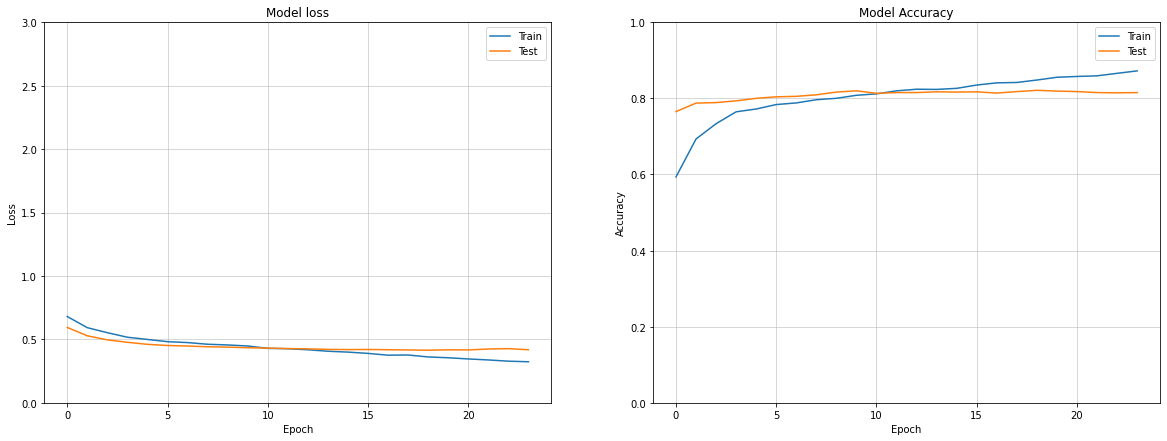

In [50]:
plot_loss_accuracy(history)

**Prochaine étape**: 
- update le fichier test
- fine-tune avec le model 'parfait'
- latent dirichlet 
- ex : passé/présent journal vs. users, type de catastrophe
- check %%time pour la présentation (de l'insertion du tweet au model.predict)